# Results

In [2]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)

import pandas as pd
from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,4)

from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmms = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)S

2022-02-02 09:15:31,625 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-02-02 09:15:32,849 - root - INFO - ** Kedro project wPCC_pipeline
2022-02-02 09:15:32,851 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-02 09:15:32,860 - root - INFO - Registered line magic `run_viz`


E:\dev\wPCC_pipeline\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
E:\dev\wPCC_pipeline\venv\lib\site-packages\mlflow\types\schema.py:49: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary = (7, np.dtype("bytes"), "BinaryType", np.object)


In [3]:
regressions = global_variables['regressions']

regression_names = ['motion_regression','force_regression']

def load_joined(join='joined'):
    df_accuracies = pd.DataFrame()
    
    for vmm_name in vmms:
        for model_test_id in model_test_ids:
            
            file_paths = []
            file_paths.append(f"{ vmm_name }.motion_regression.{join}.{model_test_id}.simulation_accuracy")
            file_paths.append(f"{ vmm_name }.force_regression.{model_test_id}.simulation_accuracy")
            
            
            for regression,file_path in zip(regression_names, file_paths):
                try:
                    accuracy = catalog.load(file_path)
                except:
                    continue
                
                accuracy = pd.Series(accuracy)
                accuracy['total'] = accuracy.mean()
                
                accuracy['vmm'] = vmm_name
                accuracy['regression'] = regression
                accuracy['model test'] = model_test_id
                
                df_accuracies = df_accuracies.append(accuracy, ignore_index=True)
                
    return df_accuracies
            

In [4]:
df_accuracies = load_joined()

2022-02-02 09:16:27,069 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.motion_regression.joined.22611.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,081 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.force_regression.22611.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,092 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.motion_regression.joined.22612.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,102 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.force_regression.22612.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,111 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.motion_regression.joined.22613.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,123 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.force_regression.22613.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,132 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.m

E:\dev\wPCC_pipeline\venv\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2022-02-02 09:16:27,859 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.force_regression.22769.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,870 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.22770.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,880 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.force_regression.22770.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,889 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.22771.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,900 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.force_regression.22771.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,910 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.22772.simulation_accuracy` (JSONDataSet)...
2022-02-02 09:16:27,919 - kedro.io.data_

In [5]:
df_compare = df_accuracies.groupby(by=['vmm','regression']).mean().sort_values(by='total', ascending=True)
df_compare

,,x0,y0,psi,total
vmm,regression,,,,
vmm_martin,motion_regression,0.178967,0.122198,0.011028,0.104064
vmm_martins_simple,force_regression,0.676050,1.014116,0.139280,0.609815
vmm_linear,motion_regression,1.280069,0.540236,0.031756,0.617354
vmm_martins_simple,motion_regression,1.570262,0.772468,0.097652,0.813461
vmm_martin,force_regression,1.988427,1.678367,0.195947,1.287580
vmm_linear,force_regression,7.408203,1.307416,0.222315,2.979311


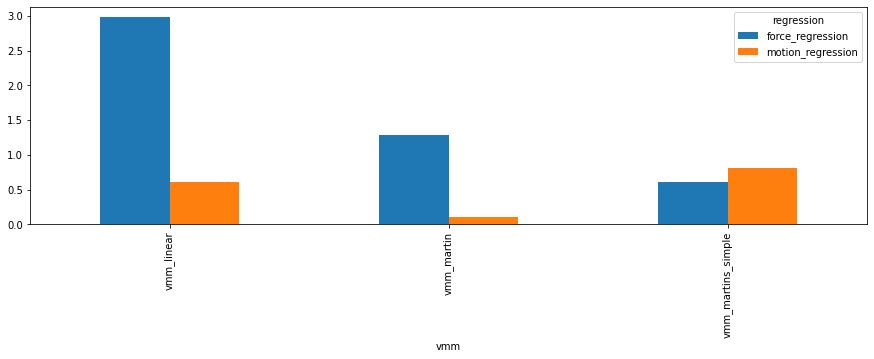

In [6]:
df_compare.reset_index().pivot(index=['vmm'], columns=['regression'], values='total').plot.bar();